# Libraries Necessary 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy as sp
import math
import random
from scipy.optimize import curve_fit,minimize
from numpy.linalg import inv
from tqdm import tqdm as tqdm

# Code for reading in the data from a run

In [2]:
#This creates a dataframe for each channel

def create_string(location):
#     path0 = '/home/drew/He6CRES/Neon-19/Data/SampleData_Michael/CH0@DT5725_1146_Data_{0:s}.csv'.format(location)
#     path2 = '/home/drew/He6CRES/Neon-19/Data/SampleData_Michael/CH2@DT5725_1146_Data_{0:s}.csv'.format(location)
    
    path0 = '/home/drew/He6CRES/Neon-19/Data/Ne19Run_09182020/CH0@DT5725_1146_Data_{0:s}.csv'.format(location)
    path2 = '/home/drew/He6CRES/Neon-19/Data/Ne19Run_09182020/CH2@DT5725_1146_Data_{0:s}.csv'.format(location)
    
    path = [path0,path2]
    return path

#def create_string(location):
    #path0 = '/home/cenpa/Ne19/DAQ/FinalConfigSettings/DAQ/{0:s}/UNFILTERED/CH0@DT5725_1146_Data_{0:s}.csv'.format(location)
    #path2 = '/home/cenpa/Ne19/DAQ/FinalConfigSettings/DAQ/{0:s}/UNFILTERED/CH2@DT5725_1146_Data_{0:s}.csv'.format(location)
    
    #path = [path0,path2]
    #return path



#write the folder location where 'BiTest-03' is
run_name = 'Ne19rundeltaE-02-22-20_5'


#ch0_df = pd.read_csv(path[0],sep=';')
#ch1_df = pd.read_csv(path[1],sep=';')

def Run_Data(run_folder_name):
    return[pd.read_csv(create_string(run_name)[i],sep=';') for i in range(2)]

# Code for splitting the data into separate cycles

In [3]:
def Split_Data(ch0_dataFrame,ch2_dataFrame,minimum_counts = 0):
    """This function returns a list of the counts data split by run for channel0 based on the triggering from channel2
    Parameters
    ----------
    ch0_dataFrame : Pandas Dataframe, counts data.
    ch2_dataFrame : Pandas Dataframe, run trigger data.
    minimum_counts : int, 
        minimum counts to remove any possible signals that may occur when not 
        running but still collecting data. Default is 0.
    Returns
    -------
    ch0split_data : Pandas Dataframe,
        Returns a list of Pandas Dataframes that correspond to each cycle in the run.
    """
    #initializing an empty list for coincidencedata ch0 
    #by the clock from ch2
    
    ch0split_data = []
    
    
    #iterating through the number of times ch2 recieved a signal from our clock
    for i in np.arange(0,len(ch2_dataFrame)-1):
        
        #creating a mask to separate the full data into their individual runs for ch0
        ch0time_mask = np.where((ch0_dataFrame['TIMETAG'] > ch2_dataFrame['TIMETAG'][i]) & 
                                (ch0_dataFrame['TIMETAG'] < ch2_dataFrame['TIMETAG'][i+1]-(80*10**12)))#pullback time in units of 10**-12 seconds
        # Note (Drew): This "pull-back" time was set to 89s by Michael. But if the cycle length is less than this you need to change it. 
        # Ch2: it was at t=64 now it's at t=0. (So maybe try to change to 25s?)
        #This number for minimum counts is to remove any possible signals that may occur when we are not running but still collecting data
        if len(ch0time_mask[0]) >= minimum_counts:
            
            #for each run I am creating a new dataframe and storing in a list
            split_dataFrame0 = ch0_dataFrame.iloc[[ch0time_mask][0][0]].copy()
            #resetting the index
            split_dataFrame0 = split_dataFrame0.reset_index(drop=True)
            
            ch0split_data.extend([split_dataFrame0])

    #returns arrays of dataframes for channel0       
    return ch0split_data

# Code for binning the data for count rate information

In [4]:
#Bin size is in units of seconds
def count_rate(single_run_coincidences,cutoff=0, bin_size = 1):
    """This function returns a list of the numpy arrays, the first array is the times in seconds and the second array is 
        the number of counts at those times based on the bin size.
    Parameters
    ----------
    single_run_coincidences : Pandas Dataframe, counts data for a single run after the data has been split.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    bin_size : int, size of the bins in unit seconds.
    Returns
    -------
    time_axis : numpy array,
        Returns values that correspond to the time binnings.
    counts : numpy array,
        Returns values that correspond to the number of counts in each of the
        time_axis bins.
    """    
    #Converting units to seconds
    bin_seconds = bin_size*(10**12)
    
    #Setting the run timetags to start at 0
    singlerun = (single_run_coincidences['TIMETAG']).where((10**-12)*single_run_coincidences['TIMETAG']>=(10**-12)*single_run_coincidences['TIMETAG'].min()+cutoff).dropna()
    singlerun = singlerun-singlerun.min()
    #Creating an array of the time spacings
    time_axis = np.arange(0,singlerun.max()-bin_seconds,bin_seconds)
    
    def time_binning(i):
        #function to create the number of 
        number_of_counts = np.where((singlerun >= i) & 
                                    (singlerun < i+bin_seconds))
        return len(number_of_counts[0])
    #returning an array of the time axis and the counts
    
    counts = np.asarray([time_binning(i) for i in time_axis])
    time_axis = time_axis*(10**-12)
    
    return time_axis, counts

# Code for plotting the counts

In [5]:
def plot_rate(coincidences,cycle_number, bin_size = 1):
    
    x,y = count_rate(coincidences[cycle_number],bin_size = bin_size)
    fig, ax = plt.subplots(1,figsize=(12,5))

    #ax.errorbar(x,y,yerr=np.sqrt(y), label= 'Limits')

    ax.plot(x,y)
    ax.set_title('Run from {0:s} Cycle Number {1:d}'.format(run_name,cycle_number))
    ax.set_ylabel('Counts')
    ax.set_xlabel('Seconds')

# Data Analysis Code

$$N=N_0 e^{-\lambda t} +B$$

$$N= {\frac  {N_{m}}{1-N_{m}D}}$$

$$M_i = \int_{T_{i-1}}^{T_i} \frac{N}{1+ND}dt$$

In [6]:
#not a very important function, but I left it in since it can be used to check approximations quickly
def Convert_Measured_to_Actual(counts,background = 0, bin_size = 1,deadtime = 0.000016):
    background_subtracted_counts = counts - background
    return background_subtracted_counts/(1-background_subtracted_counts*deadtime/bin_size)

def optimize_single_cycle(counts, binsize=1, deadtime=0.000018, rc=.039, cutoff=100):
    """This function returns a numpy minimization object for a single cycle.
    Parameters
    ----------
    counts : Pandas Dataframe, counts data for a single cycle after using the Split_Data function.
    binsize : int, size of the bins in seconds.
    deadtime : float, system deadtime in seconds.
    rc : float, ln(2)/halflife.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    Returns
    -------
    minimized_function : Numpy minimize object,
        Returns information on the minimization of the chi-squared best fit for the data.
        May return errors, but this can be due to the method numpy uses to create a hessian matrix and in most cases
        does not apply.
    """
    t,measured = count_rate(single_run_coincidences=counts, cutoff=cutoff, bin_size = binsize)
    def chisquaredfunction(params):
        D,l,N0,B = params
        
        expected = (np.log(np.absolute((D*N0*np.exp(-l*np.asarray(t[0:len(t)-1]))+B*D+1)/(D*N0*np.exp(-l*np.asarray(t[1:len(t)]))+B*D+1))) + B*D*l*(np.asarray(t[1:len(t)])-np.asarray(t[0:len(t)-1])))/(B*D*D*l+D*l)
        
        measured[0:len(measured)-1][np.where(measured[0:len(measured)-1]==0)] = 1
        chisquared = np.sum((np.square(measured[0:len(measured)-1] - expected)) / measured[0:len(measured)-1])
        return chisquared#t,measured[0:len(measured)-1],expected,chisquared
    initial_guess = [rc, measured[0]/(1-measured[0]*deadtime/binsize),B]
    minimized_function = minimize(chisquaredfunction, initial_guess)
    return minimized_function
        

#functions for doing a very quick exponential fit.   
def fit_function(t,N,l):
    return (N*np.exp((-t*l)))

def final_analysis(time,counts,rc):
    
    popt, pcov = curve_fit(fit_function, xdata=time, ydata=counts, p0=[counts[0],rc])
        

        
        
    return {'N_0' : popt[0],"Decay_Constant": popt[1],"Covariance Matrix": pcov}

$$M_i = \dfrac{\ln\left(\left|\frac{DN_0\mathrm{e}^{-\lambda T_{i-1}}+BD+1}{DN_0\mathrm{e}^{-\lambda T_i}+BD+1}\right|\right)+BD\lambda( T_i-T_{i-1})}{\left(BD^2+D\right)\lambda}$$

In [7]:
def optimize_sharedvalues(counts, binsize=1, deadtime=0.000018, rc=.039, cutoff=0):
    """This function returns a numpy minimization object for the best fit of multiple
        cycles with the same deadtime and rc.
    Parameters
    ----------
    counts : list of Pandas Dataframes, counts data for multiple cycles or all cycles in a run.
    binsize : int, size of the bins in seconds.
    deadtime : float, system deadtime in seconds.
    rc : float, ln(2)/halflife.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    Returns
    -------
    minimized_function : Numpy minimize object,
        Returns information on the minimization of the chi-squared best fit for the data.
        May return errors, but this can be due to the method numpy uses to create a hessian matrix and in most cases
        does not apply.
    """
    cycle_data = counts
    numbercycles = len(counts)
    t=[]
    measured=[]
    for i in np.arange(0,numbercycles):
        t_temporary,measured_temporary = count_rate(single_run_coincidences=cycle_data[i], cutoff=cutoff, bin_size = binsize)
        np.asarray(measured_temporary)[0:len(measured_temporary)-1][np.where(measured_temporary[0:len(measured_temporary)-1]==0)] = 1
        measured_temporary = measured_temporary[0:len(measured_temporary)-1]
        t.extend([[t_temporary]])
        measured.extend([[measured_temporary]])
    def chisquaredfun(params):

        
            
        
        D = deadtime#params[0]
        l = params[0]
        B = params[1:1+numbercycles]
        N0 = params[1+numbercycles:1+2*numbercycles]
        
        expected = []
        for i in np.arange(numbercycles):
            expected_temp = (np.log(np.absolute((D*N0[i]*np.exp(-l*np.asarray(t[i][0][0:len(t[i][0])-1]))+B[i]*D+1)/(D*N0[i]*np.exp(-l*np.asarray(t[i][0][1:len(t[i][0])]))+B[i]*D+1))) + B[i]*D*l*(np.asarray(t[i][0][1:len(t[i][0])])-np.asarray(t[i][0][0:len(t[i][0])-1])))/(B[i]*D*D*l+D*l)#the expected equation

            expected.extend([[expected_temp]])
                        
        chisquared = ((np.square(np.asarray(measured) - np.asarray(expected))) / np.asarray(measured))
        
        return np.sum([np.sum(item[0])for item in chisquared])
    B_guess = np.ones(numbercycles)
    N0_guess = [item[0][0]for item in measured]

    
    
    initial_guess = [ rc, *np.ones(numbercycles), *N0_guess ]
    
    minimized_function = minimize(chisquaredfun, initial_guess) #,method = 'L-BFGS-B', bounds = [(0.000001,.001),(.01,.05),(.01,30),(.01,30),(.01,30),(.01,30),(.01,30),(1000,None),(1000,None),(1000,None),(1000,None),(1000,None)]) 
    return minimized_function

$$N=N_0 e^{-\lambda t} + B$$

$$M_i = \frac{N_0}{\lambda}\left( e^{-\lambda T_{i-1}}- e^{-\lambda T_{i}}\right) + B(T_i - T_{i-1})$$

In [8]:
def optimize_sharedvalues_simple(counts, binsize=1, rc=.039, cutoff=0):
    """This function returns a numpy minimization object for the best fit of multiple
        cycles with the same rc with no deadtime.
    Parameters
    ----------
    counts : list of Pandas Dataframes, counts data for multiple cycles or all cycles in a run.
    binsize : int, size of the bins in seconds.
    rc : float, ln(2)/halflife.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
        cutoff is almost never 0 for this function since the data at early times
        is not close to a simple exponential.
    Returns
    -------
    minimized_function : Numpy minimize object,
        Returns information on the minimization of the chi-squared best fit for the data.
        May return errors, but this can be due to the method numpy uses to create a hessian matrix and in most cases
        does not apply.
    """
    cycle_data = counts
    numbercycles = len(counts)
    t=[]
    measured=[]
    for i in np.arange(0,numbercycles):
        t_temporary,measured_temporary = count_rate(single_run_coincidences=cycle_data[i], cutoff=cutoff, bin_size = binsize)
        np.asarray(measured_temporary)[0:len(measured_temporary)-1][np.where(measured_temporary[0:len(measured_temporary)-1]==0)] = 1
        
        measured_temporary = measured_temporary[0:len(measured_temporary)-1]
        t.extend([[t_temporary]])
        measured.extend([[measured_temporary]])
    def chisquaredfun(params):

        
            
        
        l = params[0]
        B = params[1:1+numbercycles]
        N0 = params[1+numbercycles:1+2*numbercycles]
        
        expected = []
        for i in np.arange(numbercycles):
            expected_temp = (N0[i]/l)*(np.exp(-l*np.asarray(t[i][0][0:len(t[i][0])-1]))-np.exp(-l*np.asarray(t[i][0][1:len(t[i][0])]))) + B[i]*(t[i][0][1:len(t[i][0])]-t[i][0][0:len(t[i][0])-1])

            expected.extend([[expected_temp]])
                        
        chisquared = ((np.square(np.asarray(measured) - np.asarray(expected))) / np.asarray(measured))
        
        return np.sum([np.sum(item[0])for item in chisquared])
    B_guess = np.ones(numbercycles)
    N0_guess = [item[0][0]for item in measured]

    
    
    initial_guess = [ rc, *np.ones(numbercycles), *N0_guess ]
    minimized_function = minimize(chisquaredfun, initial_guess)#,method = 'L-BFGS-B', bounds = [(.01,.05),(0,0),(0,0),(0,0),(0,0),(0,0),(1000,None),(1000,None),(1000,None),(1000,None),(1000,None)]) 
    return minimized_function

$$M_i = \dfrac{\ln(DN_0e^{-\lambda T_{i-1}}+BD+1)}{D(BD+1)\lambda}-\dfrac{\ln(DN_0e^{-\lambda T_{i}}+BD+1)}{D(BD+1)\lambda} + \dfrac{B(T_i - T_{i-1})}{BD+1}$$

$$x - \frac{x^2}{2} + \frac{x^3}{3} - \frac{x^4}{4} + \frac{x^5}{5} - \frac{x^6}{6} + O(x^7)$$
(Taylor series)
(converges when abs(x)<1)

B = 0 (can make data reflect this condition)

$$M_i = \frac{N_0e^{-\lambda T_{i-1}}}{\lambda} - \frac{N_0e^{-\lambda T_{i}}}{\lambda} - \frac{D(N_0e^{-\lambda T_{i-1}})^2}{\lambda} +\frac{D(N_0e^{-\lambda T_{i}})^2}{\lambda}+...$$

In [9]:
def optimize_sharedvalues_expanded(counts, binsize=1, deadtime=0.000016, rc=.039, cutoff=0):
    """
    This function returns a numpy minimization object for the best fit of multiple
        cycles with the same deadtime and rc and uses an approximation with no background counts.
        Used more as a tool to check rather than a tool for analysis.
    Parameters
    ----------
    counts : list of Pandas Dataframes, counts data for multiple cycles or all cycles in a run.
    binsize : int, size of the bins in seconds.
    deadtime : float, system deadtime in seconds.
    rc : float, ln(2)/halflife.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    Returns
    -------
    minimized_function : Numpy minimize object,
        Returns information on the minimization of the chi-squared best fit for the data.
        May return errors, but this can be due to the method numpy uses to create a hessian matrix and in most cases
        does not apply.
    """
    cycle_data = counts
    numbercycles = len(counts)
    t=[]
    measured=[]
    for i in np.arange(0,numbercycles):
        t_temporary,measured_temporary = count_rate(single_run_coincidences=cycle_data[i], cutoff=cutoff, bin_size = binsize)
        np.asarray(measured_temporary)[0:len(measured_temporary)-1][np.where(measured_temporary[0:len(measured_temporary)-1]==0)] = 1
        
        measured_temporary = measured_temporary[0:len(measured_temporary)-1]
        t.extend([[t_temporary]])
        measured.extend([[measured_temporary]])
    def chisquaredfun(params):

        
            
        D = params[1]
        l = params[0]
        N0 = params[2:2+numbercycles]
        
        
        expected = []
        for i in np.arange(numbercycles):
            expected_temp = (N0[i]*np.exp(-l*np.asarray(t[i][0][0:len(t[i][0])-1])))/l - (N0[i]*np.exp(-l*np.asarray(t[i][0][1:len(t[i][0])])))/l - D*((N0[i]*np.exp(-l*np.asarray(t[i][0][0:len(t[i][0])-1])))**2 - (N0[i]*np.exp(-l*np.asarray(t[i][0][1:len(t[i][0])])))**2)/l #+ (D**2)*((N0[i]*np.exp(-l*np.asarray(t[i][0][0:len(t[i][0])-1])))**3 - (N0[i]*np.exp(-l*np.asarray(t[i][0][1:len(t[i][0])])))**3)/l

            expected.extend([[expected_temp]])
                        
        chisquared = ((np.square(np.asarray(measured) - np.asarray(expected))) / np.asarray(measured))
        
        return np.sum([np.sum(item[0])for item in chisquared])
    B_guess = np.ones(numbercycles)
    N0_guess = [item[0][0]for item in measured]

    
    
    initial_guess = [rc,deadtime , *N0_guess ]
    minimized_function = minimize(chisquaredfun, initial_guess)#,method = 'L-BFGS-B', bounds = [(.01,.05),(0,.00001),(1000,None),(1000,None),(1000,None),(1000,None),(1000,None)]) 
    return minimized_function 

In [10]:
def residuals(counts,cycle_number,values, binsize=1, cutoff=0,):
    """
    This function returns a dictionary with residuals information for a simple exponential fit.
    Parameters
    ----------
    counts : Pandas Dataframe, counts data for a single cycle.
    binsize : int, size of the bins in seconds.
    values : minimized_fuction.x, the values from the minimization best fit.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    Returns
    -------
    'time' : array of time values
    'residuals' : array of normalized residuals
    'fit' : array of best fit values
    'measured' : array of measured values
    """
    numbercycles = len(counts)
    t,measured = count_rate(single_run_coincidences=counts[cycle_number], cutoff=cutoff, bin_size = binsize)
    def residual(params):
        l = params[0]
        B = params[1:1+numbercycles]
        N0 = params[1+numbercycles:1+2*numbercycles]
        
        expected = (N0[cycle_number]/l)*(np.exp(-l*np.asarray(t[0:len(t)-1]))-np.exp(-l*np.asarray(t[1:len(t)]))) + B[cycle_number]*(t[1:len(t)]-t[0:len(t)-1])

        measured[0:len(measured)-1][np.where(measured[0:len(measured)-1]==0)] = 1
        residuals = (expected - measured[0:len(measured)-1] ) / np.sqrt(measured[0:len(measured)-1])
        return residuals, expected, measured
    res, exp, meas= residual(values)
    return dict(time = t[0:len(t)-1],
                residuals = res,
                fit = exp,
                measured = meas)

In [11]:
def residuals_deadtime(counts,cycle_number,values, binsize=1, cutoff=0,deadtime=1.8e-5):
    """
    This function returns a dictionary with residuals information for a deadtime model fit.
    Parameters
    ----------
    counts : Pandas Dataframe, counts data for a single cycle.
    cycle_number : int, cycle number based on the list indexing in the Split_Data function. First cycle = 0.
    values : minimized_fuction.x, the values from the minimization best fit.
    binsize : int, size of the bins in seconds.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    deadtime : float, system deadtime in seconds.
    Returns
    -------
    'time' : array of time values
    'residuals' : array of normalized residuals
    'fit' : array of best fit values
    'measured' : array of measured values
    """
    numbercycles = len(counts)
    t,measured = count_rate(single_run_coincidences=counts[cycle_number], cutoff=cutoff, bin_size = binsize)
    def residual(params):
        #D = params[0]
        D = deadtime
        l = params[0]
        B = params[1:1+numbercycles]
        N0 = params[1+numbercycles:1+2*numbercycles]
        
        expected = (np.log(np.absolute((D*N0[cycle_number]*np.exp(-l*np.asarray(t[0:len(t)-1]))+B[cycle_number]*D+1)/(D*N0[cycle_number]*np.exp(-l*np.asarray(t[1:len(t)]))+B[cycle_number]*D+1))) + B[cycle_number]*D*l*(np.asarray(t[1:len(t)])-np.asarray(t[0:len(t)-1])))/(B[cycle_number]*D*D*l+D*l)


        measured[0:len(measured)-1][np.where(measured[0:len(measured)-1]==0)] = 1
        residuals = (expected - measured[0:len(measured)-1] ) / np.sqrt(measured[0:len(measured)-1])
        return residuals, expected, measured
    res, exp, meas= residual(values)
    return dict(time = t[0:len(t)-1],
                residuals = res,
                fit = exp,
                measured = meas)

$$  y(x_i;a) = \sum_{j=0} \frac{N_{0,i}}{\lambda}\left( e^{-\lambda T_{i-1}}- e^{-\lambda T_{i}}\right) + B_i(T_i - T_{i-1}) $$

$$\alpha_{k,l} = \sum^{N}_{i=1} \frac{1}{\sigma_i^2} \left[ \frac{\partial y(x_i; \bf a)}{\partial a_k} \cdot \frac{\partial y(x_i; \bf a)}{\partial a_l} \right]$$

$$\frac{\partial y(x_i;\bf a)}{\partial \lambda} = \sum_{j=0} -\frac{N_{0,i}}{\lambda^2}\left( e^{-\lambda T_{i-1}}- e^{-\lambda T_{i}}\right) + \frac{N_{0,i}}{\lambda}\left( - T_{i-1}e^{-\lambda T_{i-1}}+  T_{i}e^{-\lambda T_{i}}\right)$$

$$\frac{\partial y(x_i;\bf a)}{\partial N_{0,i}} = \frac{1}{\lambda}\left( e^{-\lambda T_{i-1}}- e^{-\lambda T_{i}}\right)$$

$$\frac{\partial y(x_i;\bf a)}{\partial B_i} = (T_i - T_{i-1})$$


In [12]:
def covariance_matrix(best_fit_parameters,counts ,cutoff, binsize):
    """
    This function returns the covariance matrix for a exponential fit.
    Parameters
    ----------
    best_fit_parameters : list, values of the best fit parameters from the minimization function.
    counts : list of Pandas Dataframes, counts data for multiple cycles or all cycles in a run.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    binsize : int, size of the bins in seconds.
    Returns
    -------
    covariance_matrix : matrix in order of rc,background counts_0,... background counts_i, initial counts_0, initial counts_i.
    """    
    cycle_data = counts
    numbercycles = len(counts)
    t=[]
    measured=[]
    for i in np.arange(0,numbercycles):
        t_temporary,measured_temporary = count_rate(single_run_coincidences=cycle_data[i], cutoff=cutoff, bin_size = binsize)
        np.asarray(measured_temporary)[0:len(measured_temporary)-1][np.where(measured_temporary[0:len(measured_temporary)-1]==0)] = 1
        t_temporary = t_temporary[0:int(210/binsize)-cutoff]
        measured_temporary = measured_temporary[0:int(210/binsize)-cutoff]
        t.extend([[t_temporary]])
        measured.extend([[measured_temporary]])
    
    l = best_fit_parameters[0]
    B = best_fit_parameters[1:1+numbercycles]
    N0 = best_fit_parameters[1+numbercycles:1+2*numbercycles]

    
    def yB(time,std):
        return (time[1:len(time)] - time[0:len(time)-1])/np.sqrt(std[0:len(std)-1])
    
    def yl(timelist,l,stdlist,Nlist):
        y=0
        for i in np.arange(len(Nlist)):
            y= y+(-(Nlist[i]/(l**2))*(np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1]) - np.exp(-l*timelist[i][0][1:len(timelist[i][0])])) + (Nlist[i]/l)*(-timelist[i][0][0:len(timelist[i][0])-1]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+timelist[i][0][1:len(timelist[i][0])]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])))/np.sqrt(stdlist[i][0][0:len(stdlist[i][0])-1])
            
        return np.asarray(y)
    
    def yN0(time,l,std):
        return (1/l)*(np.exp(-l*time[0:len(time)-1])-np.exp(-l*time[1:len(time)]))/np.sqrt(std[0:len(std)-1])
    
    unique_values = [yl(t,l,measured,N0)]
    
    for i in np.arange(numbercycles):
        unique_values.extend([yB(t[i][0],measured[i][0])])
        
    for i in np.arange(numbercycles):
        unique_values.extend([yN0(t[i][0],l,measured[i][0])])

    
    hessian=[]
    for i in np.arange(0,1+numbercycles*2):
        for j in np.arange(0,1+numbercycles*2):
            hessian.extend([np.sum(unique_values[i]*unique_values[j])])
    
    h = np.asarray(hessian)
    
    #hessian = np.array([[a11,a12,a13,a14],[a12,a22,a23,a24],[a13,a23,a33,a34],[a14,a24,a34,a44]])
    covariance_matrix =  inv(h.reshape((1+numbercycles*2,1+numbercycles*2)))
    return covariance_matrix

$$  y(x_i;a) = \sum_{j=0} \dfrac{\ln\left(\left|\frac{DN_{0,i}\mathrm{e}^{-\lambda T_{i-1}}+B_iD+1}{DN_{0,i}\mathrm{e}^{-\lambda T_i}+B_iD+1}\right|\right)+B_iD\lambda( T_i-T_{i-1})}{\left(B_iD^2+D\right)\lambda} $$

In [13]:
from sympy import sym

L, d, n, b, ti, ti1 = syp.symbols('l D N B ti ti1', real = True)
init_printing(use_unicode=True)

expression = (sym.log((d*n*sym.exp(-L*ti1)+b*d+1)/(d*n*sym.exp(-L*ti)+b*d+1)) + b*d*L*(ti-ti1))/(d*L*(b*d+1))

ImportError: cannot import name 'sym' from 'sympy' (/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/sympy/__init__.py)

In [ ]:
def covariance_matrixd(best_fit_parameters,counts,deadtime ,cutoff, binsize):
    """
    This function returns the covariance matrix for a deadtime model fit.
    Parameters
    ----------
    best_fit_parameters : list, values of the best fit parameters from the minimization function.
    counts : list of Pandas Dataframes, counts data for multiple cycles or all cycles in a run.
    deadtime : float, system deadtime in seconds.
    cutoff : int, a time in seconds to indicate where to start making the bins after t=0.
    binsize : int, size of the bins in seconds.
    Returns
    -------
    covariance_matrix : matrix in order of deadtime,rc,background counts_0,... background counts_i, initial counts_0, initial counts_i.
    """      
    cycle_data = counts
    numbercycles = len(counts)
    t=[]
    measured=[]
    for i in np.arange(0,numbercycles):
        t_temporary,measured_temporary = count_rate(single_run_coincidences=cycle_data[i], cutoff=cutoff, bin_size = binsize)
        np.asarray(measured_temporary)[0:len(measured_temporary)-1][np.where(measured_temporary[0:len(measured_temporary)-1]==0)] = 1
        t_temporary = t_temporary[0:int(210/binsize)-cutoff]
        measured_temporary = measured_temporary[0:int(210/binsize)-cutoff]
        t.extend([[t_temporary]])
        measured.extend([[measured_temporary]])
    
    D = deadtime
    l = best_fit_parameters[0]
    B = best_fit_parameters[1:1+numbercycles]
    N0 = best_fit_parameters[1+numbercycles:1+2*numbercycles]

    
    def yB(timelist,l,D,stdlist,N,B,i):
        y = (-1*((B*D*l*(timelist[i][0][1:len(timelist[i][0])]-timelist[i][0][0:len(timelist[i][0])-1])+np.log((B*D+D*N*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)/(B*D+D*N*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1))))/(l*(B*D+1)**2)+(D*l*(timelist[i][0][1:len(timelist[i][0])]-timelist[i][0][0:len(timelist[i][0])-1])+(((D/(B*D+D*N*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1))-(D*(B*D+D*N*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)/(B*D+D*N*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)**2 ))*(B*D+D*N*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)/(1+B*D+D*N*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])))/(D*l*(B*D+1))))/np.sqrt(stdlist[i][0][0:len(stdlist[i][0])-1])
        return np.asarray(y)
    
    def yl(timelist,l,D,stdlist,Nlist,Blist):
        y=0
        for i in np.arange(len(Nlist)):
            y += ((Blist[i]*D*(timelist[i][0][1:len(timelist[i][0])]-timelist[i][0][0:len(timelist[i][0])-1])+((D*Nlist[i]*timelist[i][0][1:len(timelist[i][0])]*(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)**2-(D*Nlist[i]*timelist[i][0][0:len(timelist[i][0])-1]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1]))/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1))*(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1))/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1))/(D*l*(Blist[i]*D+1)) - (Blist[i]*D*l*(timelist[i][0][1:len(timelist[i][0])]-timelist[i][0][0:len(timelist[i][0])-1])+np.log((Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)))/(D*(l**2)*(Blist[i]*D+1)))/np.sqrt(stdlist[i][0][0:len(stdlist[i][0])-1])
        return np.asarray(y)
    
    def yN0(timelist,l,D,stdlist,N,B,i):
        y = (((D*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])/(B*D+D*N*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1) - (D*(B*D+D*N*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)*np.exp(-l*timelist[i][0][1:len(timelist[i][0])]))/(B*D+D*N*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)**2)*(B*D+D*N*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1))/(D*l*(B*D+1)*(B*D+D*N*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)))/np.sqrt(stdlist[i][0][0:len(stdlist[i][0])-1])
        return np.asarray(y)
    
    def yD(timelist,l,D,stdlist,Nlist,Blist):
        y=0
        for i in np.arange(len(Nlist)):
            
            y += (-(Blist[i]*(Blist[i]*D*l*(timelist[i][0][1:len(timelist[i][0])]-timelist[i][0][0:len(timelist[i][0])-1])+np.log((Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1))))/(D*l*(Blist[i]*D+1)**2)  +  (Blist[i]*l*(timelist[i][0][1:len(timelist[i][0])]-timelist[i][0][0:len(timelist[i][0])-1])+((((-Blist[i]-Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])]))*(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1))/((Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)**2))+(Blist[i]+Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1]))/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1))*(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1))/(D*l*(Blist[i]*D+1))  -  (Blist[i]*D*l*(timelist[i][0][1:len(timelist[i][0])]-timelist[i][0][0:len(timelist[i][0])-1])+np.log((Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][0:len(timelist[i][0])-1])+1)/(Blist[i]*D+D*Nlist[i]*np.exp(-l*timelist[i][0][1:len(timelist[i][0])])+1)))/((D**2)*l*(Blist[i]*D+1)))/np.sqrt(stdlist[i][0][0:len(stdlist[i][0])-1])
        return np.asarray(y)
    
    unique_values = [yD(t,l,D,measured,N0,B)]
    unique_values.extend([yl(t,l,D,measured,N0,B)])
    for i in np.arange(numbercycles):
        unique_values.extend([yB(t,l,D,measured,N0[i],B[i],i)])
    for i in np.arange(numbercycles):
        unique_values.extend([yN0(t,l,D,measured,N0[i],B[i],i)])

    
    hessian=[]
    for i in np.arange(0,2+numbercycles*2):
        for j in np.arange(0,2+numbercycles*2):
            hessian.extend([np.sum(unique_values[i]*unique_values[j])])
    
    h = np.asarray(hessian)
    
    #hessian = np.array([[a11,a12,a13,a14],[a12,a22,a23,a24],[a13,a23,a33,a34],[a14,a24,a34,a44]])
    covariance_matrix =  inv(h.reshape((2+numbercycles*2,2+numbercycles*2)))
    return covariance_matrix

# Example Use:

## Create a pandas dataframe of the counts for ch1 and ch2 of the digitizer

In [14]:
# Redefine run_name for tests

run_name = 'runTEST09182020_2'
# run_name = 'Ne19rundeltaE-02-22-20_5'
data = Run_Data(run_name)

0              0.000025
1              0.000077
2              0.000094
3              0.000198
4              0.000211
               ...     
13861059    2084.074667
13861060    2095.055600
13861061    2095.616214
13861062    2098.997996
13861063    2109.118894
Name: TIMETAG, Length: 13861064, dtype: float64


,TIMETAG,ENERGY,ENERGYSHORT,FLAGS
0,24628271,467,322,0x4000
1,77292032,467,358,0x4000
2,94064100,475,333,0x4000
3,197516272,467,322,0x4000
4,210972524,465,318,0x4000
...,...,...,...,...
13861059,2084074666800324,467,320,0x4000
13861060,2095055600320100,475,333,0x4000
13861061,2095616214496074,479,338,0x4000
13861062,2098997995549156,466,315,0x4000


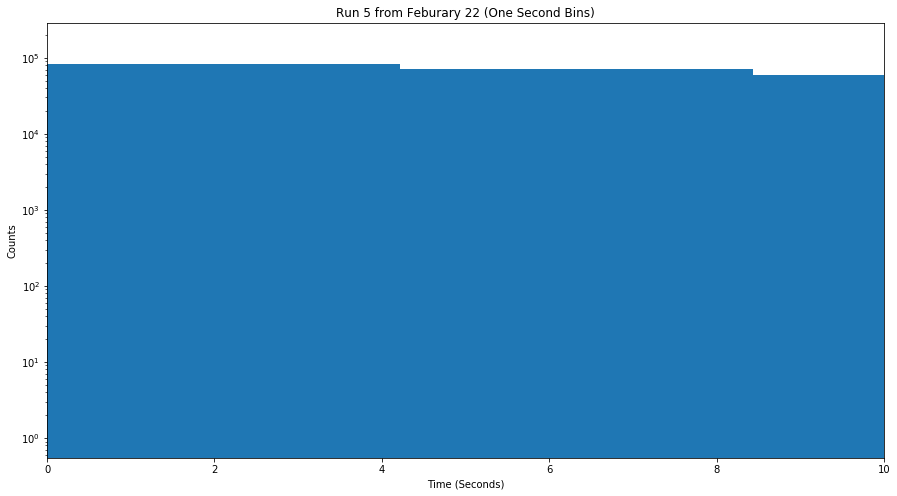

In [15]:
#data for channel 0
# print(data[0])
# print(data[1])
# #Test Plot of data
# test = data[0]
# test.plot()
plt.figure(figsize=(15,8))
plt.tight_layout()
plt.title('Run 5 from Feburary 22 (One Second Bins)')
plt.ylabel('Counts')
plt.xlabel('Time (Seconds)')
plt.xlim(0,10)
plt.yscale('log')
plt.hist(data[0]['TIMETAG']*10**-12,bins=500);
plt.savefig('Run 5')

# 10 bins: 500/10 = 50s*1/3s = 17 counts per bin. Makes sense
print(data[0]['TIMETAG']*10**-12)

# With source: We are seeing roughly 30 Hz. This means that the (3s) cycles should have roughly 90 events each.

data[0]

## Split the data into the individual cycles

In [16]:
cycles = Split_Data(data[0],data[1])

In [17]:
#Data for channel 0 split by the triggering in channel 1
cycles

[                 TIMETAG  ENERGY  ENERGYSHORT   FLAGS
 0        180925701612171     470          326  0x4000
 1        180925717988049     475          353  0x4000
 2        180926030200075     479          339  0x4000
 3        180926639376127     472          330  0x4000
 4        180926651836046     907          354  0x4000
 ...                  ...     ...          ...     ...
 2273953  345950805812086     478          336  0x4000
 2273954  345953149084079     478          337  0x4000
 2273955  345960210972087     931          335  0x4000
 2273956  345960880588105     474          331  0x4000
 2273957  345961189344064     479          345  0x4000
 
 [2273958 rows x 4 columns],
                  TIMETAG  ENERGY  ENERGYSHORT   FLAGS
 0        425962310420049     471          355  0x4000
 1        425962596532179     470          326  0x4000
 2        425962878720047     475          352  0x4000
 3        425963148016375     467          320  0x4000
 4        425963297684076     478 

## Example of how to find the best fit deadtime:

In [18]:
#this takes a while to run, deadtime = 1.853e-05 for cutoff = 0 for data right now
deadtimelist = np.arange(40e-9,50e-9,.1e-9)
fitlist = []
for i in tqdm(deadtimelist):
    op2 = optimize_sharedvalues(cycles[1:4],cutoff=70,deadtime=i,binsize=1)
    fitlist[0:0] = [op2]
fitlist.reverse()

# np.arange(1e-9,1e-7,1e-9) # Shows how flat the fit is. Hard to identify a reasonable minimum.
# np.arange(4e-8,8e-8,1e-9) # Shows zooming in on the minimum. 
# Note: Gate was 40 ns for these cycles. 

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


## Plotting the Deadtime minimization:

(array([4.47e-08]), array([521.52609846]))

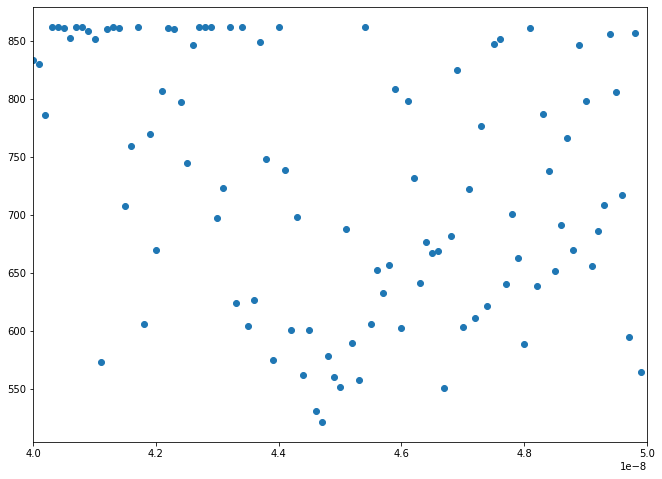

In [19]:

plt.figure(figsize=(11,8))

chilist = np.asarray([fitlist[i].fun for i in np.arange(0,len(fitlist)) ])
plt.scatter(deadtimelist,chilist)
plt.xlim(40e-9,50e-9)
# plt.ylim(0,100)

#Finding the deadtime that corresponds to the minimum chi-squared value
np.asarray(deadtimelist)[np.where(chilist==chilist.min())],chilist[np.where(chilist==chilist.min())]
# print(chilist)

## Find the best fit for shared deadtime and halflife using a simple exponential

In [33]:
op = optimize_sharedvalues_simple(cycles[0:3],cutoff=70,binsize=1)

In [34]:
op

      fun: 453.36356030059596
 hess_inv: array([[ 3.15208431e-09,  1.59930841e-04, -2.10003293e-04,
        -2.76764896e-04, -2.55481305e-04, -1.90181965e-04,
         1.36649078e-04],
       [ 1.59930841e-04,  1.83746287e+01, -7.96191618e+00,
        -1.09101456e+01, -6.96669839e+00,  4.98863434e+00,
         5.48574750e+00],
       [-2.10003293e-04, -7.96191618e+00,  7.60039809e+01,
         8.88606077e+01,  6.45384683e+01,  6.37316731e+01,
        -9.31705792e+01],
       [-2.76764896e-04, -1.09101456e+01,  8.88606077e+01,
         1.27637236e+02,  8.07559932e+01,  7.93946453e+01,
        -1.26192499e+02],
       [-2.55481305e-04, -6.96669839e+00,  6.45384683e+01,
         8.07559932e+01,  6.30235999e+01,  6.98718073e+01,
        -6.84554448e+01],
       [-1.90181965e-04,  4.98863434e+00,  6.37316731e+01,
         7.93946453e+01,  6.98718073e+01,  9.92779174e+01,
        -4.88366550e+01],
       [ 1.36649078e-04,  5.48574750e+00, -9.31705792e+01,
        -1.26192499e+02, -6.84554448

## Plot the residuals

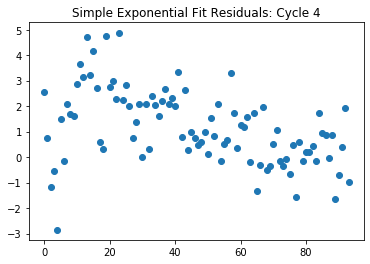

In [35]:
res = residuals(counts=cycles[0:4],cycle_number=0,values=op.x,binsize=1,cutoff=70)
# len(res['time'])*5 # What is this for? (DREW)

plt.scatter(res['time'],res['residuals'])
plt.title('Simple Exponential Fit Residuals: Cycle 4');
plt.savefig('simpcycle4res.png')

In [41]:
def dfit(m,D):
    return (1/(1-m*D))

m = lambda lam, D, n_0, t: (n_0*np.exp(-lam*t))/(1+n_0*np.exp(-lam*t)*D)

t_half = 17 # (s)
lam = np.log(2)/t_half # (Hz)
n_0 = 1.89663847e+04 # (Hz)
D = 50*10**-6 # (s)

t = np.arange(0,t_half*10,1) #(s)

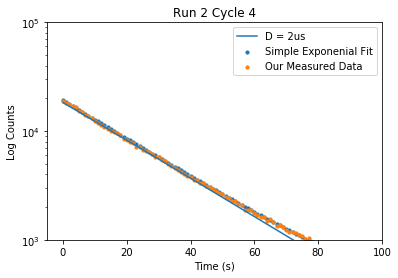

In [49]:
plt.scatter(res['time'],res['fit'],s=10,label="Simple Exponenial Fit")
plt.scatter(res['time'],res['measured'][0:len(res['time'])],s=10,label="Our Measured Data")
i = 2 # (us)
D = i*10**-6  
plt.plot(t,m(lam,D,n_0,t), label= 'D = {}us'.format(i))

plt.xlim(-5,100)
plt.ylim(10**3,10**5)
plt.title('Run 2 Cycle 4');
plt.ylabel('Log Counts')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig('cutoff70simpcycle4.png')

## Find the best fit for shared deadtime and halflife using the deadtime model

In [122]:
opd = optimize_sharedvalues(cycles[0:4],cutoff=70,deadtime=3e-11,binsize=1)

In [123]:
opd

      fun: 1392.5274428192756
 hess_inv: array([[ 4.99811369e-10,  3.76595008e-06,  8.37283618e-10,
         3.78247442e-06,  2.95876266e-07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.91958544e-07],
       [ 3.76595008e-06,  1.00067853e+00,  5.81208059e-06,
         6.63317257e-04, -3.60601934e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.80890590e-05],
       [ 8.37283618e-10,  5.81208059e-06,  2.91403788e-09,
         5.85488837e-06,  5.27702356e-07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -5.29301460e-07],
       [ 3.78247442e-06,  6.63317257e-04,  5.85488837e-06,
         1.00064845e+00, -3.49629901e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.68518164e-05],
       [ 2.95876266e-07, -3.60601934e-05,  5.27702356e-07,
        -3.49629901e-05,  5.00006125e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -5.00003978e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0

## Plot the residuals

In [124]:
resd = residuals_deadtime(counts=cycles[0:3],cycle_number=1,values=opd.x,binsize=1,cutoff=70)
len(resd['time'])

94

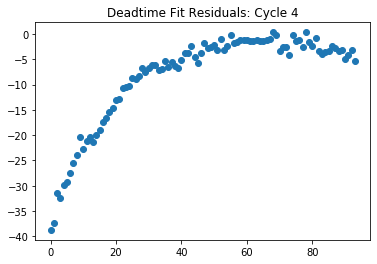

In [125]:
plt.scatter(resd['time'],resd['residuals'])
plt.title('Deadtime Fit Residuals: Cycle 4');


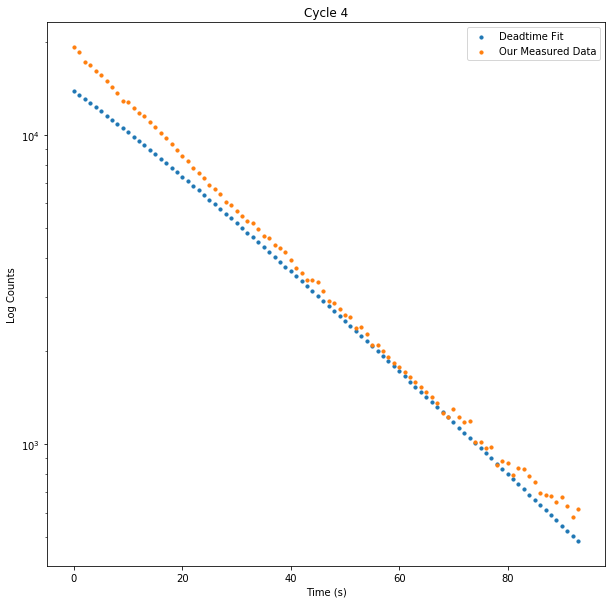

In [103]:
plt.figure(figsize=(10,10))
plt.scatter(resd['time'],resd['fit'],s=10,label="Deadtime Fit")
plt.scatter(resd['time'],resd['measured'][0:len(resd['time'])],s=10,label="Our Measured Data")
plt.yscale('log')
plt.title('Cycle 4');
plt.ylabel('Log Counts')
plt.xlabel('Time (s)')
plt.legend();


## Covariance Matrix

In [89]:
#covariance matrix for the deadtime model
cm = covariance_matrixd(opd.x,cycles,1.853e-05,0,1)

ValueError: arange: cannot compute length

In [96]:
np.sqrt(np.diagonal(cm))

array([4.87189008e-06, 4.14279243e-05, 6.70857165e+04, 6.21420855e+04,
       6.58789405e+04, 3.99864723e+04, 8.07539585e+04, 1.01481684e+05,
       9.67765152e+04, 9.99761498e+04, 6.87016080e+04, 1.31028389e+05])

In [100]:
#fit halflife
np.log(2)/(opd.x[0])

(16.90258350930515, 0.017092785915096442)

In [101]:
#relative error, formatted in order: decay constant,Background counts, N0 counts 
np.sqrt(np.diagonal(cm)[1:])/op.x

array([ 1.18149402e-03, -3.47575415e+03, -3.09546696e+03, -3.33556818e+03,
       -1.99094764e+03, -3.84814690e+03,  4.01248008e+00,  3.77316725e+00,
        3.92620125e+00,  2.46299699e+00,  4.87707148e+00])

## Other plots code that may be useful in the future

In [1]:
plt.figure(figsize=(15,8))
plt.tight_layout()
plt.title('Run 5 from Feburary 22 (One Second Bins)')
plt.ylabel('Counts')
plt.xlabel('Time (Seconds)')
plt.xlim(0,1865)
plt.yscale('log')
plt.hist(data[0]['TIMETAG']*10**-12,bins=1865);
plt.savefig('Run 5')

NameError: name 'plt' is not defined

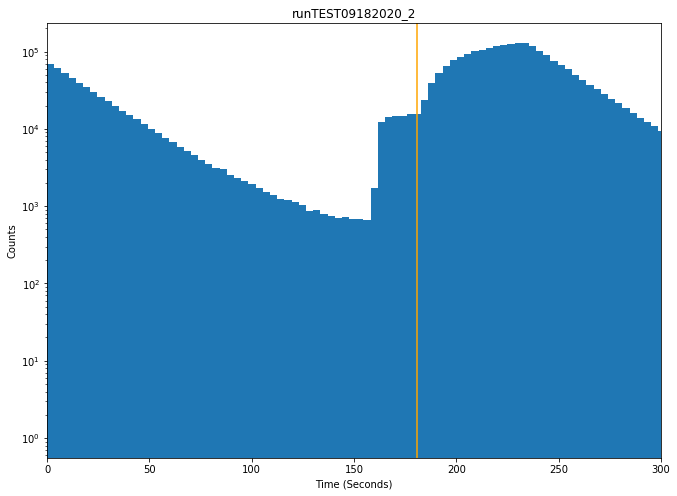

In [44]:
plt.figure(figsize=(11,8))
plt.title('{}'.format(run_name))
plt.ylabel('Counts')
plt.xlabel('Time (Seconds)')
plt.xlim(0,300)
xcoords = data[1]['TIMETAG']*10**-12
for xc in xcoords:
    plt.axvline(x=xc,color='orange')
plt.hist(data[0]['TIMETAG']*10**-12,bins=600);
plt.xlim(0,300)
plt.yscale('log')
plt.savefig('Splits')

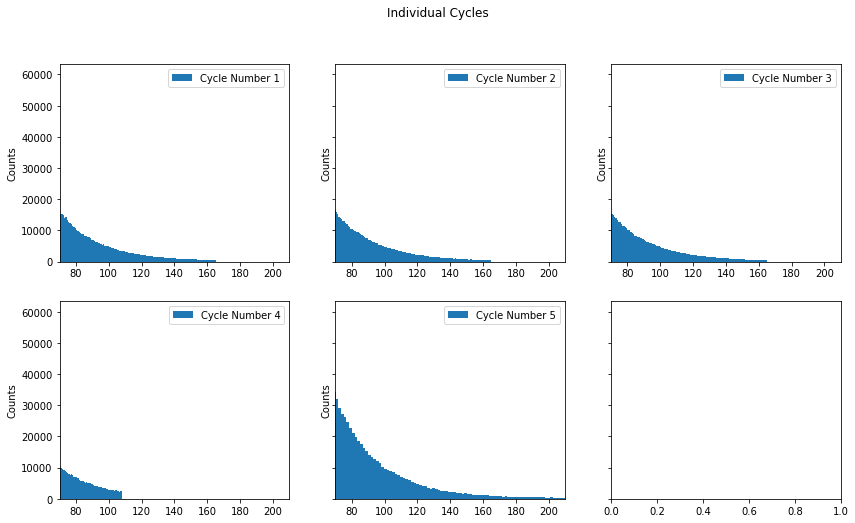

In [97]:
fig,ax = plt.subplots(2,3,figsize=(14,8),sharey=True)
fig.suptitle('Individual Cycles')
l=0

for i in np.arange(0,2):
    for j in np.arange(0,3):
        if l<=4:
            ax[i][j].hist((cycles[l]['TIMETAG']-np.min(cycles[l]['TIMETAG']))*10**-12,bins = 200,label='Cycle Number {0:d}'.format(l+1));
            ax[i][j].legend()
            ax[i][j].set_ylabel('Counts')
            ax[i][j].set_xlim(70,210)
#             ax[i][j].set_yscale('log') # Why does this not work?

            l+=1
plt.savefig('Cycles')

ValueError: x and y must be the same size

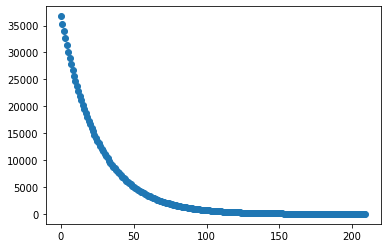

In [98]:
x = np.arange(0,210)
y = 2.29015061e+03*np.exp(-3.96412971e-02*np.arange(-70,210-70))+1.66666139e+00
plt.scatter(x,y,label = 'Backwards Extrapolated Fit')
plt.scatter(x,resd['measured'][0:210],label = 'Measured Data')
plt.xlim(0,210)
plt.title('Measured Data and Extrapolated Data')
plt.ylabel('Counts/second')
plt.xlabel('Time')
plt.legend();
#plt.savefig('Extrapolatedexponentialfit.png')

In [35]:
sub = (y/resd['measured'][0:210])

def dfit(m,D):
    return (1/(1-m*D))

def analysis(m,ratio):
    
    popt, pcov = curve_fit(dfit, xdata=m, ydata=ratio, p0=[1.853e-05])
    return(popt,pcov)

In [36]:
analysis(resd['measured'][0:210],sub)

(array([-0.00017887]), array([[7.46860805e-10]]))

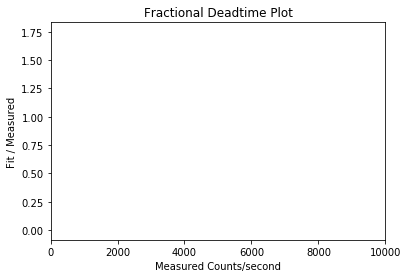

In [37]:
plt.plot(resd['measured'][0:210],sub)
plt.title('Fractional Deadtime Plot')
plt.xlim(resd['measured'][0:210].min(),resd['measured'][0:210].max())
plt.plot(resd['measured'][0:210],1/(1 - 1.853e-05*resd['measured'][0:210]))
plt.ylabel('Fit / Measured')
plt.xlim(0,10000)
plt.xlabel('Measured Counts/second');
#plt.savefig('fractionaldeadtime.png')

(0, 10000)

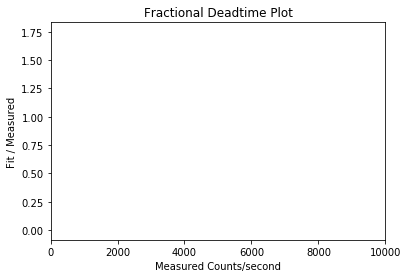

In [38]:
plt.plot(resd['measured'][0:210],sub)
plt.title('Fractional Deadtime Plot')
plt.xlim(resd['measured'][0:210].min(),resd['measured'][0:210].max())
plt.plot(resd['measured'][0:210],1/(1 - 1.853e-05*resd['measured'][0:210]))
plt.ylabel('Fit / Measured')
plt.xlabel('Measured Counts/second');
plt.xlim(0,10000)
#plt.savefig('fractionaldeadtime.png')

(0, 10000)

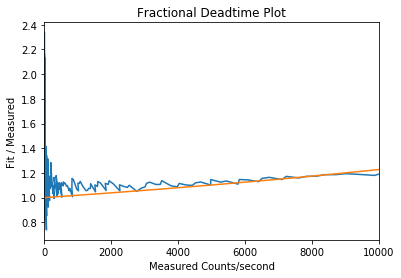

In [268]:
plt.plot(resd['measured'][0:210],sub)
plt.title('Fractional Deadtime Plot')
plt.xlim(resd['measured'][0:210].min(),resd['measured'][0:210].max())
plt.plot(resd['measured'][0:210],1/(1 - 1.853e-05*resd['measured'][0:210]))
plt.ylabel('Fit / Measured')
plt.xlabel('Measured Counts/second');
plt.xlim(0,10000)
#plt.savefig('fractionaldeadtime.png')

(0, 10000)

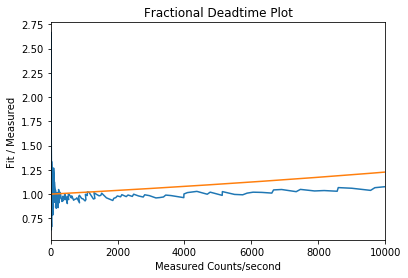

In [273]:
plt.plot(resd['measured'][0:210],sub)
plt.title('Fractional Deadtime Plot')
plt.xlim(resd['measured'][0:210].min(),resd['measured'][0:210].max())
plt.plot(resd['measured'][0:210],1/(1 - 1.853e-05*resd['measured'][0:210]))
plt.ylabel('Fit / Measured')
plt.xlabel('Measured Counts/second');
plt.xlim(0,10000)
#plt.savefig('fractionaldeadtime.png')

(0, 10000)

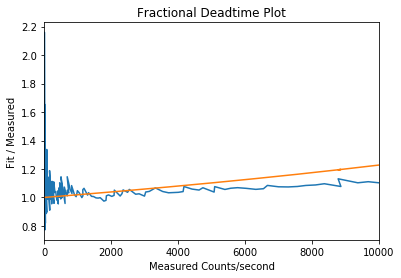

In [278]:
plt.plot(resd['measured'][0:210],sub)
plt.title('Fractional Deadtime Plot')
plt.xlim(resd['measured'][0:210].min(),resd['measured'][0:210].max())
plt.plot(resd['measured'][0:210],1/(1 - 1.853e-05*resd['measured'][0:210]))
plt.ylabel('Fit / Measured')
plt.xlabel('Measured Counts/second');
plt.xlim(0,10000)

In [97]:
t,c = count_rate(cycles[1], cutoff = 70, bin_size = .5)
t
c

array([9794, 9397, 9320, 9204, 8669, 8472, 8539, 8327, 8072, 7968, 7883,
       7665, 7475, 7422, 7227, 7002, 6806, 6838, 6522, 6296, 6442, 6308,
       6153, 6042, 5932, 5832, 5763, 5766, 5540, 5498, 5409, 5206, 5212,
       4914, 4921, 4833, 4646, 4673, 4565, 4396, 4276, 4256, 4255, 3998,
       3904, 3878, 3850, 3676, 3610, 3659, 3594, 3296, 3361, 3329, 3197,
       3235, 2996, 3090, 3042, 2909, 2921, 2768, 2767, 2691, 2641, 2634,
       2740, 2430, 2519, 2459, 2404, 2300, 2389, 2246, 2231, 2176, 2199,
       2115, 2122, 2071, 1953, 1989, 1849, 1865, 1793, 1791, 1734, 1652,
       1672, 1714, 1683, 1660, 1572, 1547, 1475, 1418, 1450, 1400, 1375,
       1358, 1259, 1353, 1306, 1266, 1176, 1199, 1170, 1220, 1154, 1117,
       1090,  996, 1059, 1026, 1018,  977,  979,  928,  928,  906,  879,
        895,  847,  867,  829,  822,  771,  814,  784,  748,  763,  716,
        717,  702,  672,  688,  645,  614,  620,  607,  668,  633,  587,
        637,  585,  592,  627,  565,  538,  482,  5

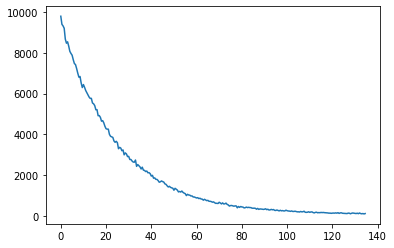

In [98]:
plt.plot(t,c)

# Plotting the Runs from Sept  2020 Production run. 

* This may not be the place to keep this. Going to need to reorganize. But for now I need it here. 

0
1
2
3
4
5
6
7
9


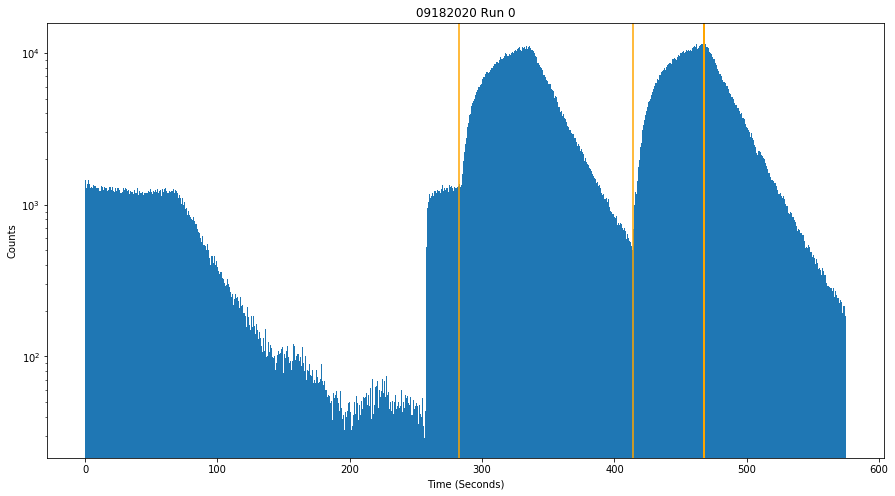

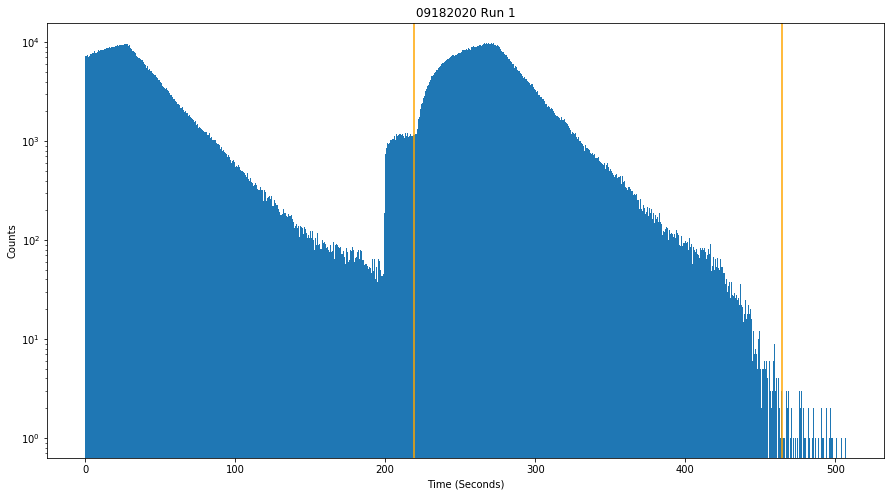

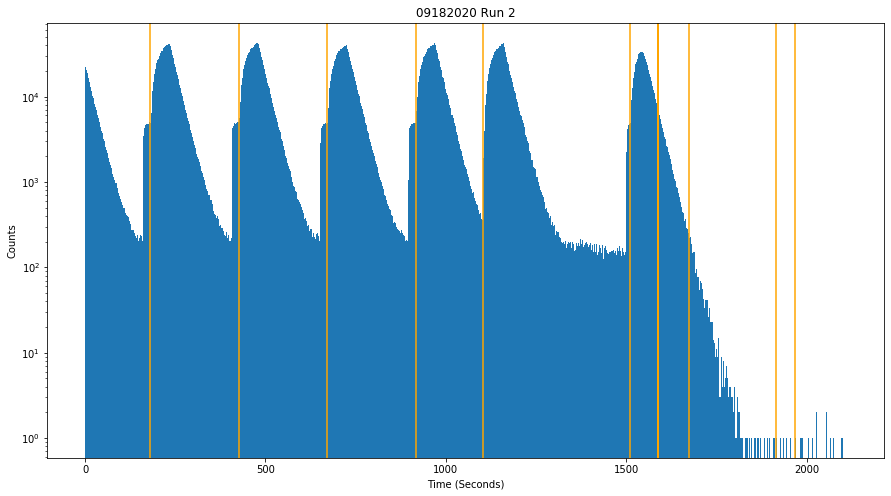

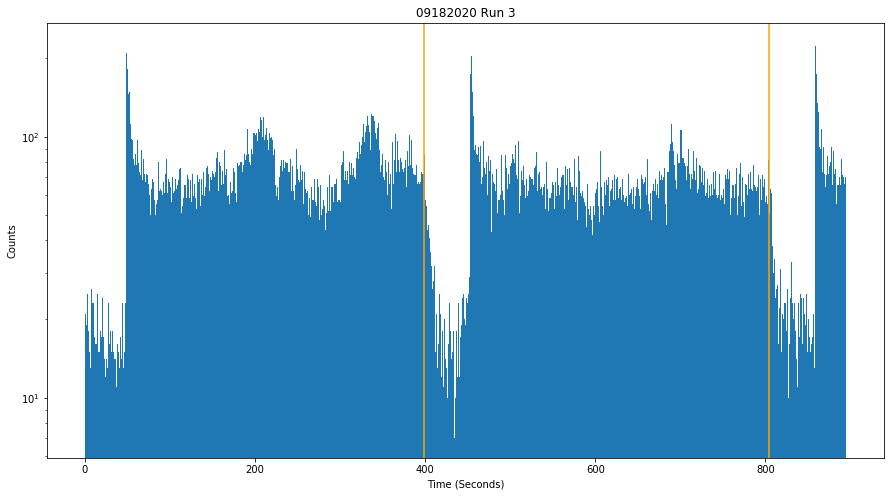

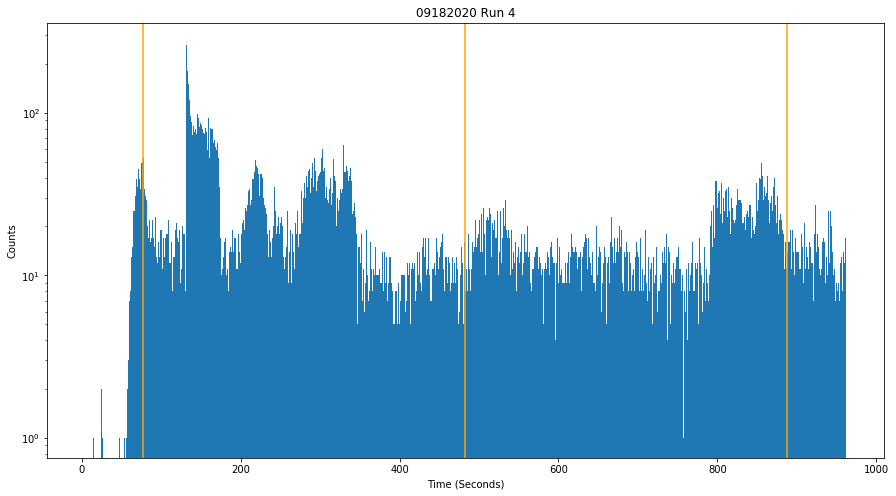

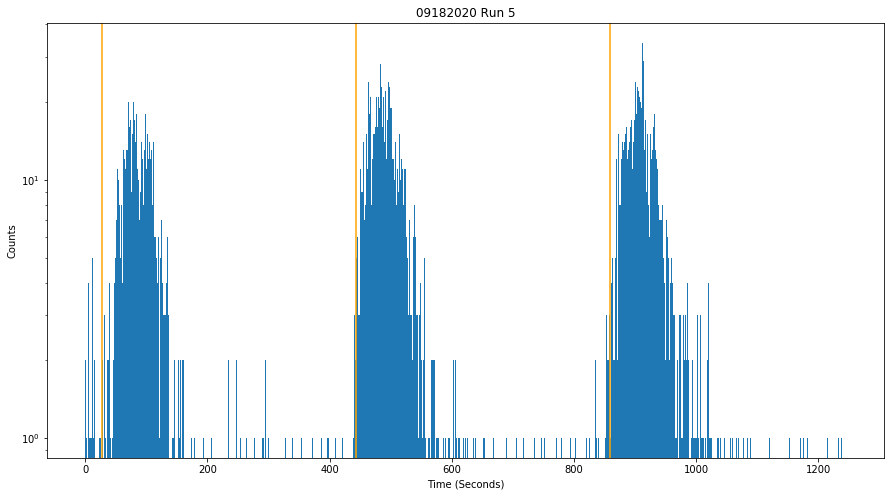

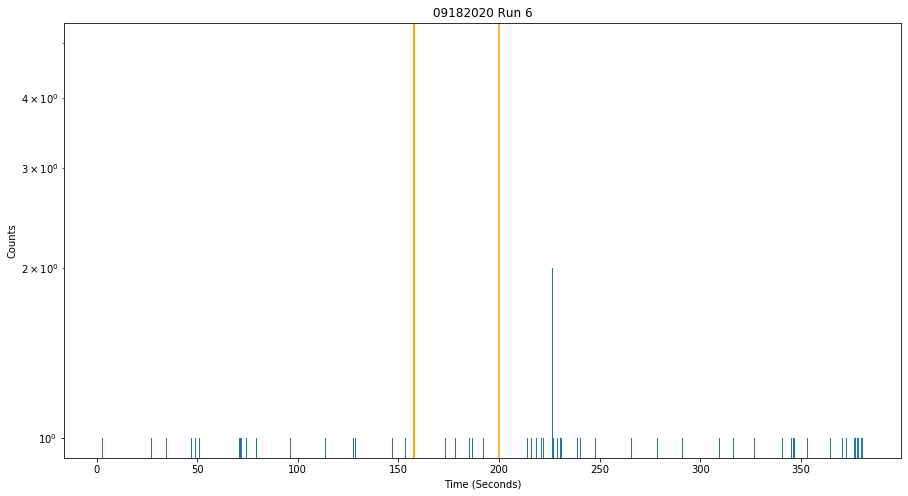

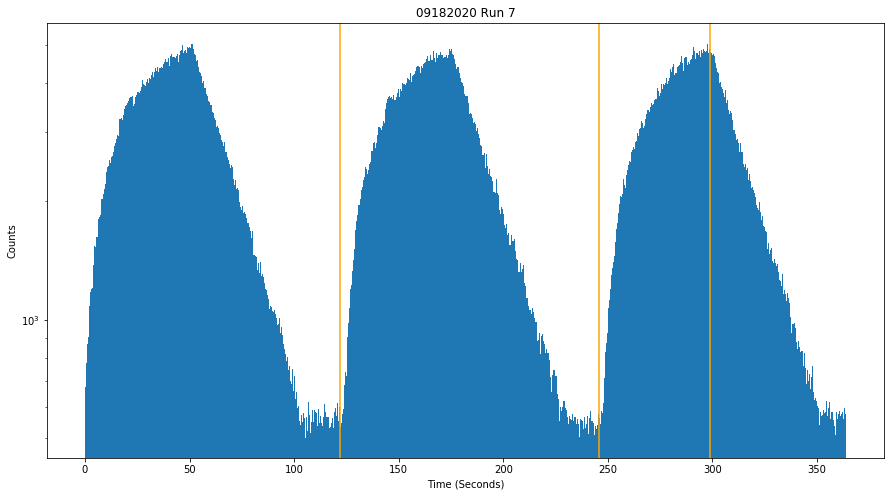

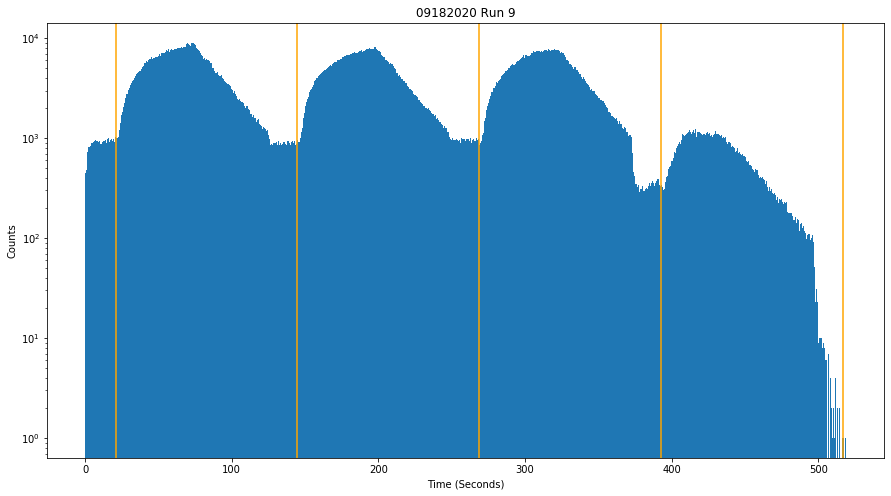

In [5]:
# Redefine run_name for tests

for i in range(10):
    if i==8: continue 
    print(i)
    run_name = 'runTEST09182020_{}'.format(i)
    data = Run_Data(run_name)

    plt.figure(figsize=(15,8))
    plt.tight_layout()
    plt.title('09182020 Run {}'.format(i))
    plt.ylabel('Counts')
    plt.xlabel('Time (Seconds)')
    plt.yscale('log')
    xcoords = data[1]['TIMETAG']*10**-12
    for xc in xcoords:
        plt.axvline(x=xc,color='orange')
    plt.hist(data[0]['TIMETAG']*10**-12,bins=1865);
    plt.savefig('09182020 Run {}'.format(i))